# Pre-Process

In [1]:
import pandas as pd
import numpy as np
df= pd.read_csv("compas-scores-two-years.csv")
df = df.loc[df["race"].isin(["African-American", "Caucasian"])]
df["race"].replace(['African-American', 'Caucasian'],[0, 1], inplace=True)
df["score_text"].replace(["Low","Medium","High"],[0,1,2],inplace=True)
df["sex"].replace(["Male","Female"],[0,1],inplace=True)
df["c_charge_degree"].replace(["M","F"],[0,1],inplace=True)
df["priors_count"] = np.where(df['priors_count'] > 0, 1, 0)
juv_cond = (df['juv_fel_count'] > 0) | (df['juv_misd_count'] > 0) | (df['juv_other_count'] > 0)
df['juv_count'] = np.where(juv_cond, 1, 0)

In [2]:
y = df["two_year_recid"]
X = pd.DataFrame(df, columns=["race","age","priors_count","juv_count",'score_text',"sex","c_charge_degree"])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=1/7, random_state=67, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train, X_valid, y_train, y_valid=train_test_split(X_train,y_train,test_size=879, random_state=67, stratify=y_train)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(5271, 7) (5271,) (879, 7) (879,)
(4392, 7) (4392,) (879, 7) (879,)


# Baseline

In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test,y_test)

0.6666666666666666

In [4]:
index_b= (X_test["race"]==0)
X_test_b=X_test[index_b]
y_test_b=y_test[index_b]
X_test_w=X_test[-index_b]
y_test_w=y_test[-index_b]

(522, 7) (357, 7)


In [5]:
index_b= (X_train["race"]==0)
X_train_b=X_train[index_b]
y_train_b=y_train[index_b]
X_train_w=X_train[-index_b]
y_train_w=y_train[-index_b]

(2626, 7) (1766, 7)


In [6]:
#calibration
print(clf.score(X_test_b,y_test_b))
print(clf.score(X_test_w,y_test_w))
print("calibration score: ",abs(clf.score(X_test_b,y_test_b)-clf.score(X_test_w,y_test_w)))

0.6475095785440613
0.6946778711484594
calibration score:  0.04716829260439803


# A5

# A6

## Determine e

In [7]:
print(np.sum(clf.predict(X_train_b)==1)/len(X_train_b))
print(np.sum(clf.predict(X_train_w)==1)/len(X_train_w))
D_all=np.sum(clf.predict(X_train_b)==1)/len(X_train_b)-np.sum(clf.predict(X_train_w)==1)/len(X_train_w)
print("D_all:", D_all)

0.5003808073115004
0.2480181200453001
D_all: 0.25236268726620026


In [8]:
def D_bad_function(x):
    
    # Making male and female subsets of black people:
    B_dataset = X_train_b.groupby(x)
    W_dataset = X_train_w.groupby(x)

    # Total unique values in "sex" column
    n = np.sum(B_dataset[x].nunique())
    
    e = []
    for i in range(n):
        e.append((np.sum(clf.predict(B_dataset.get_group(i))==1)/len(B_dataset.get_group(i))+np.sum(clf.predict(W_dataset.get_group(i))==1)/len(W_dataset.get_group(i)))/n)

    d = []
    for i in range(n):
        d.append((len(B_dataset.get_group(i))/len(X_train_b)-len(W_dataset.get_group(i))/len(X_train_w))*e[i])
    
    D_exp = np.sum(d)
    
    return(D_all-D_exp)

In [9]:
D_bad_all=[D_bad_function("sex"),D_bad_function("priors_count"),D_bad_function("juv_count"),
           D_bad_function("c_charge_degree"),D_bad_function("score_text")]

([<matplotlib.axis.XTick at 0x7fbb30fab8d0>,
 [Text(0.0, 0, 'sex'),
  Text(1.0, 0, 'priors_count'),
  Text(2.0, 0, 'juv_count'),
  Text(3.0, 0, 'c_charge_degree'),
  Text(4.0, 0, 'score_text')])

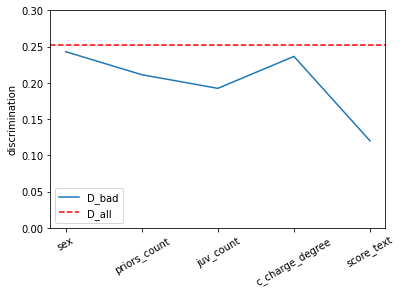

In [10]:
import matplotlib.pyplot as plt
plt.plot(D_bad_all)
plt.axhline(y = D_all, color = 'r', linestyle = '--')
plt.ylabel("discrimination")
plt.ylim([0,0.3])
plt.legend(["D_bad","D_all"])
plt.xticks([0.0,1.0,2.0,3.0,4.0],["sex","priors_count","juv_count","c_charge_degree","score_text"],rotation=30)

## Algorithm: Local massaging

In [11]:
#split X_train into different sex, 0:low, 1:medium, 2:high
index_0= (X_train["score_text"]==0)
X_train_0=X_train[index_0]
y_train_0=y_train[index_0]
index_1= (X_train["score_text"]==1)
X_train_1=X_train[index_1]
y_train_1=y_train[index_1]
index_2= (X_train["score_text"]==2)
X_train_2=X_train[index_2]
y_train_2=y_train[index_2]
print(X_train_0.shape,X_train_1.shape,X_train_2.shape)

(2237, 7) (1207, 7) (948, 7)


In [12]:
from sklearn.linear_model import LogisticRegression
clf_0 = LogisticRegression(random_state=0).fit(X_train_0, y_train_0)
clf_1 = LogisticRegression(random_state=0).fit(X_train_1, y_train_1)
clf_2 = LogisticRegression(random_state=0).fit(X_train_2, y_train_2)

In [13]:
#get probability for logistic regression
X_train_0["prob_0"],X_train_0["prob_1"]=clf_0.predict_proba(X_train_0)[:,0],clf_0.predict_proba(X_train_0)[:,1]
X_train_1["prob_0"],X_train_1["prob_1"]=clf_1.predict_proba(X_train_1)[:,0],clf_1.predict_proba(X_train_1)[:,1]
X_train_2["prob_0"],X_train_2["prob_1"]=clf_2.predict_proba(X_train_2)[:,0],clf_2.predict_proba(X_train_2)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [14]:
index_b= (X_train["race"]==0)
X_train_b=X_train[index_b]
y_train_b=y_train[index_b]
X_train_w=X_train[-index_b]
y_train_w=y_train[-index_b]
print(X_train_b.shape,X_train_w.shape)

(2626, 7) (1766, 7)


In [15]:
index_b_0= (X_train_b["score_text"]==0)
X_train_b_0=X_train_b[index_b_0]
y_train_b_0=y_train_b[index_b_0]
index_b_1= (X_train_b["score_text"]==1)
X_train_b_1=X_train_b[index_b_1]
y_train_b_1=y_train_b[index_b_1]
index_b_2= (X_train_b["score_text"]==2)
X_train_b_2=X_train_b[index_b_2]
y_train_b_2=y_train_b[index_b_2]

index_w_0= (X_train_w["score_text"]==0)
X_train_w_0=X_train_w[index_w_0]
y_train_w_0=y_train_w[index_w_0]
index_w_1= (X_train_w["score_text"]==1)
X_train_w_1=X_train_w[index_w_1]
y_train_w_1=y_train_w[index_w_1]
index_w_2= (X_train_w["score_text"]==2)
X_train_w_2=X_train_w[index_w_2]
y_train_w_2=y_train_w[index_w_2]

print(X_train_b_0.shape,X_train_b_1.shape,X_train_b_2.shape,X_train_w_0.shape,X_train_w_1.shape,X_train_w_2.shape)

(1084, 7) (808, 7) (734, 7) (1153, 7) (399, 7) (214, 7)


In [16]:
#e_0
p_plus_e_0=(np.sum(clf_0.predict(X_train_b_0)==1)/len(X_train_b_0)+np.sum(clf_0.predict(X_train_w_0)==1)/len(X_train_w_0))/2
#e_1
p_plus_e_1=(np.sum(clf_1.predict(X_train_b_1)==1)/len(X_train_b_1)+np.sum(clf_1.predict(X_train_w_1)==1)/len(X_train_w_1))/2
#e_2
p_plus_e_2=(np.sum(clf_2.predict(X_train_b_2)==1)/len(X_train_b_2)+np.sum(clf_2.predict(X_train_w_2)==1)/len(X_train_w_2))/2

In [17]:

delta_b_0=abs(int(len(X_train_b_0)*(np.sum(clf_0.predict(X_train_b_0)==1)/len(X_train_b_0)-p_plus_e_0)))
delta_w_0=abs(int(len(X_train_w_0)*(np.sum(clf_0.predict(X_train_w_0)==1)/len(X_train_w_0)-p_plus_e_0)))

delta_b_1=abs(int(len(X_train_b_1)*(np.sum(clf_1.predict(X_train_b_1)==1)/len(X_train_b_1)-p_plus_e_1)))
delta_w_1=abs(int(len(X_train_w_1)*(np.sum(clf_1.predict(X_train_w_1)==1)/len(X_train_w_1)-p_plus_e_1)))

delta_b_2=abs(int(len(X_train_b_2)*(np.sum(clf_2.predict(X_train_b_2)==1)/len(X_train_b_2)-p_plus_e_2)))
delta_w_2=abs(int(len(X_train_w_2)*(np.sum(clf_2.predict(X_train_w_2)==1)/len(X_train_w_2)-p_plus_e_2)))
print(delta_b_0,delta_w_0,delta_b_1,delta_w_1,delta_b_2,delta_w_2)

21 23 24 11 8 2


In [18]:
index_p_to_n_0=X_train_0[(X_train_0["prob_1"]>=0.5)&(X_train_0["race"]==0)]["prob_1"].sort_values()[:delta_b_0]
index_n_to_p_0=X_train_0[(X_train_0["prob_1"]<0.5)&(X_train_0["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_0]

index_p_to_n_1=X_train_1[(X_train_1["prob_1"]>=0.5)&(X_train_1["race"]==0)]["prob_1"].sort_values()[:delta_b_1]
index_n_to_p_1=X_train_1[(X_train_1["prob_1"]<0.5)&(X_train_1["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_1]

index_p_to_n_2=X_train_2[(X_train_2["prob_1"]>=0.5)&(X_train_2["race"]==0)]["prob_1"].sort_values()[:delta_b_2]
index_n_to_p_2=X_train_2[(X_train_2["prob_1"]<0.5)&(X_train_2["race"]==1)]["prob_1"].sort_values(ascending=False)[:delta_w_2]

In [19]:
y_train_new=y_train.copy()
y_train_new[y_train_new.index.isin(index_p_to_n_0.index)]=0
y_train_new[y_train_new.index.isin(index_n_to_p_0.index)]=1
y_train_new[y_train_new.index.isin(index_p_to_n_1.index)]=0
y_train_new[y_train_new.index.isin(index_n_to_p_1.index)]=1
y_train_new[y_train_new.index.isin(index_p_to_n_2.index)]=0
y_train_new[y_train_new.index.isin(index_n_to_p_2.index)]=1

In [20]:
from sklearn.linear_model import LogisticRegression
clf_new = LogisticRegression(random_state=0).fit(X_train, y_train_new)
clf_new.score(X_test,y_test)

0.6723549488054608

In [21]:
print("calibration score: ",abs(clf_new.score(X_test_b,y_test_b)-clf_new.score(X_test_w,y_test_w)))

calibration score:  0.04702340706397501


## Algorithm: Local preferential sampling

In [22]:
index_p_to_n_0_u=X_train_0[(X_train_0["prob_1"]>=0.5)&(X_train_0["race"]==0)]["prob_1"].sort_values()[:int(delta_b_0/2)]
index_p_to_n_0_d=X_train_0[(X_train_0["prob_1"]<0.5)&(X_train_0["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_0/2)]

index_n_to_p_0_d=X_train_0[(X_train_0["prob_1"]<0.5)&(X_train_0["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_0/2)]
index_n_to_p_0_u=X_train_0[(X_train_0["prob_1"]>=0.5)&(X_train_0["race"]==1)]["prob_1"].sort_values()[:int(delta_w_0/2)]

index_p_to_n_1_u=X_train_1[(X_train_1["prob_1"]>=0.5)&(X_train_1["race"]==0)]["prob_1"].sort_values()[:int(delta_b_1/2)]
index_p_to_n_1_d=X_train_1[(X_train_1["prob_1"]<0.5)&(X_train_1["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_1/2)]

index_n_to_p_1_d=X_train_1[(X_train_1["prob_1"]<0.5)&(X_train_1["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_1/2)]
index_n_to_p_1_u=X_train_1[(X_train_1["prob_1"]>=0.5)&(X_train_1["race"]==1)]["prob_1"].sort_values()[:int(delta_w_1/2)]

index_p_to_n_2_u=X_train_2[(X_train_2["prob_1"]>=0.5)&(X_train_2["race"]==0)]["prob_1"].sort_values()[:int(delta_b_2/2)]
index_p_to_n_2_d=X_train_2[(X_train_2["prob_1"]<0.5)&(X_train_2["race"]==0)]["prob_1"].sort_values(ascending=False)[:int(delta_b_2/2)]

index_n_to_p_2_d=X_train_2[(X_train_2["prob_1"]<0.5)&(X_train_2["race"]==1)]["prob_1"].sort_values(ascending=False)[:int(delta_w_2/2)]
index_n_to_p_2_u=X_train_2[(X_train_2["prob_1"]>=0.5)&(X_train_2["race"]==1)]["prob_1"].sort_values()[:int(delta_w_2/2)]

In [23]:
X_train_new1=X_train.copy()
y_train_new1=y_train.copy()
df_new=pd.concat([X_train_new1,y_train_new1],axis=1)
df_new.drop(index_p_to_n_0_d.index,inplace=True)
df_new.drop(index_n_to_p_0_u.index,inplace=True)
df_new.drop(index_p_to_n_1_d.index,inplace=True)
df_new.drop(index_n_to_p_1_u.index,inplace=True)
df_new.drop(index_p_to_n_2_d.index,inplace=True)
df_new.drop(index_n_to_p_2_u.index,inplace=True)

In [24]:
df_dup_1=df_new[df_new.index.isin(index_p_to_n_0_u.index)]
df_dup_2=df_new[df_new.index.isin(index_n_to_p_0_d.index)]
df_dup_3=df_new[df_new.index.isin(index_p_to_n_1_u.index)]
df_dup_4=df_new[df_new.index.isin(index_n_to_p_1_d.index)]
df_dup_5=df_new[df_new.index.isin(index_p_to_n_2_u.index)]
df_dup_6=df_new[df_new.index.isin(index_n_to_p_2_d.index)]
df_new_all=df_new.append([df_dup_1,df_dup_2,df_dup_3,df_dup_4,df_dup_4,df_dup_4])

In [25]:
print(df_new.shape,X_train_new1.shape,df_new_all.shape)

(4350, 8) (4392, 7) (4398, 8)


In [26]:
from sklearn.linear_model import LogisticRegression
clf_new1 = LogisticRegression(random_state=0).fit(df_new_all.drop("two_year_recid",axis=1), df_new_all["two_year_recid"])
print(clf_new1.score(X_test,y_test))
print("calibration score: ",abs(clf_new1.score(X_test_b,y_test_b)-clf_new1.score(X_test_w,y_test_w)))

0.6689419795221843
calibration score:  0.03390321645899741


# Comparision plots:

## Accuracy plot:

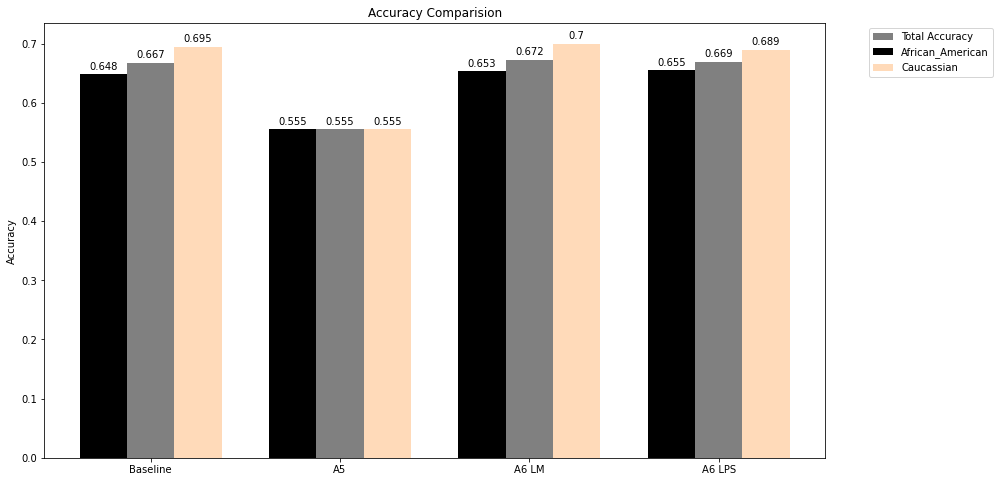

In [27]:
labels = ['Baseline', 'A5', 'A6 LM', 'A6 LPS']   # Add other models here

# Replace 0.555 with true scores:
Accuracy_score             = np.round_([clf.score(X_test,y_test),0.555, clf_new.score(X_test,y_test),clf_new1.score(X_test,y_test)],3)
Accuracy_African_American  = np.round_([clf.score(X_test_b,y_test_b),0.555,clf_new.score(X_test_b,y_test_b),clf_new1.score(X_test_b,y_test_b)],3)
Accuracy_Caucassian        = np.round_([clf.score(X_test_w,y_test_w),0.555,clf_new.score(X_test_w,y_test_w),clf_new1.score(X_test_w,y_test_w)],3)

x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 8))

rects0 = ax.bar(x , Accuracy_score , width, label='Total Accuracy', color="gray")
rects1 = ax.bar(x - width, Accuracy_African_American, width, label='African_American', color = "black")
rects2 = ax.bar(x + width, Accuracy_Caucassian, width, label='Caucassian', color = "peachpuff")

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparision')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

## Calibration plot:

Text(0.5, 1.0, 'Calibration score Comparision')

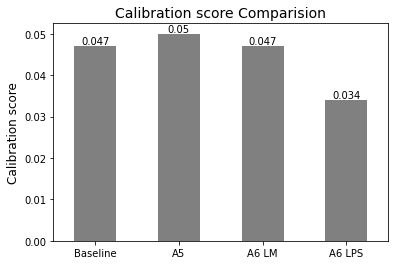

In [28]:
x_labels = ['Baseline','A5', 'A6 LM', 'A6 LPS']

Baseline_cal_score = abs(clf.score(X_test_b,y_test_b)-clf.score(X_test_w,y_test_w))
A5_cal_score = 0.05          # Enter score here
A6_LM_cal_score = abs(clf_new.score(X_test_b,y_test_b)-clf_new.score(X_test_w,y_test_w))
A6_LPS_cal_score = abs(clf_new1.score(X_test_b,y_test_b)-clf_new1.score(X_test_w,y_test_w))      # Enter score here

Calibration_score = np.round([Baseline_cal_score,A5_cal_score,A6_LM_cal_score,A6_LPS_cal_score],3)

score_series = pd.Series(Calibration_score)

plt.figure()
fig = score_series.plot(kind='bar',color="gray")
fig.set_xticklabels(x_labels, rotation=0)
fig.bar_label(fig.containers[0], label_type='edge')
plt.ylabel('Calibration score',fontsize = 12)
plt.title('Calibration score Comparision',fontsize = 14)

## False Positive Rate plot:

In [29]:
#FPR for baseline
from sklearn.metrics import confusion_matrix
y_pred_T = clf.predict(X_test)
CM_T = confusion_matrix(y_test, y_pred_T)

TN_T = CM_T[0][0]
FN_T = CM_T[1][0]
TP_T = CM_T[1][1]
FP_T = CM_T[0][1]

FPR_T = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T)

# African American FPR

y_pred_b = clf.predict(X_test_b)
CM_b = confusion_matrix(y_test_b, y_pred_b)

TN_b = CM_b[0][0]
FP_b = CM_b[0][1]

FPR_b = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b)

# Caucasian FPR

y_pred_w = clf.predict(X_test_w)
CM_w = confusion_matrix(y_test_w, y_pred_w)

TN_w = CM_w [0][0]
FP_w = CM_w [0][1]

FPR_w = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w)

Total FPR:  0.24733475479744135
African American FPR:  0.340080971659919
Caucasian FPR:  0.14414414414414414


In [30]:
# FPR for A6 LM

# Overall FPR
y_pred_T = clf_new.predict(X_test)
CM_T = confusion_matrix(y_test, y_pred_T)
TN_T = CM_T[0][0]
FP_T = CM_T[0][1]
FPR_T_LM = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T_LM)


# African American FPR
y_pred_b = clf_new.predict(X_test_b)
CM_b = confusion_matrix(y_test_b, y_pred_b)
TN_b = CM_b[0][0]
FP_b = CM_b[0][1]
FPR_b_LM = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b_LM)


# Caucasian FPR
y_pred_w = clf_new.predict(X_test_w)
CM_w = confusion_matrix(y_test_w, y_pred_w)
TN_w = CM_w [0][0]
FP_w = CM_w [0][1]
FPR_w_LM = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w_LM)

Total FPR:  0.23880597014925373
African American FPR:  0.31983805668016196
Caucasian FPR:  0.14864864864864866


In [31]:
# FPR for A6 LPS
from sklearn.metrics import confusion_matrix
# Overall FPR
y_pred_T = clf_new1.predict(X_test)
CM_T = confusion_matrix(y_test, y_pred_T)
TN_T = CM_T[0][0]
FP_T = CM_T[0][1]
FPR_T_LPS = FP_T/(FP_T+TN_T)
print("Total FPR: ",FPR_T_LPS)

# African American FPR
y_pred_b = clf_new1.predict(X_test_b)
CM_b = confusion_matrix(y_test_b, y_pred_b)
TN_b = CM_b[0][0]
FP_b = CM_b[0][1]
FPR_b_LPS = FP_b/(FP_b+TN_b)
print("African American FPR: ",FPR_b_LPS)

# Caucasian FPR
y_pred_w = clf_new1.predict(X_test_w)
CM_w = confusion_matrix(y_test_w, y_pred_w)
TN_w = CM_w [0][0]
FP_w = CM_w [0][1]
FPR_w_LPS = FP_w/(FP_w+TN_w)
print("Caucasian FPR: ",FPR_w_LPS)

Total FPR:  0.24520255863539445
African American FPR:  0.3360323886639676
Caucasian FPR:  0.14414414414414414


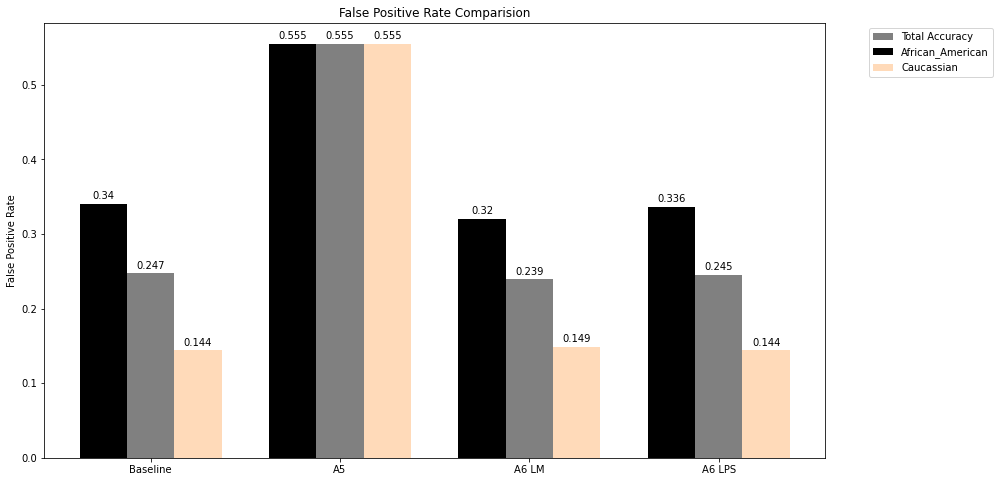

In [32]:
labels = ['Baseline', 'A5', 'A6 LM', 'A6 LPS']   # Add other models here

# Insert scores here:
FPR_score             = np.round_([FPR_T,0.555, FPR_T_LM, FPR_T_LPS],3)
FPR_African_American  = np.round_([FPR_b,0.555, FPR_b_LM, FPR_b_LPS],3)
FPR_Caucassian        = np.round_([FPR_w,0.555, FPR_w_LM, FPR_w_LPS],3)

x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(14, 8))

rects0 = ax.bar(x , FPR_score  , width, label='Total Accuracy', color="gray")
rects1 = ax.bar(x - width, FPR_African_American, width, label='African_American', color = "black")
rects2 = ax.bar(x + width, FPR_Caucassian, width, label='Caucassian', color = "peachpuff")

ax.set_ylabel('False Positive Rate')
ax.set_title('False Positive Rate Comparision')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.bar_label(rects0, padding=3)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()